# Pre processing


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import data

In [8]:
df = pd.read_csv('Bhopal.csv')

plot time series

In [9]:
import pandas as pd

df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df = df[df['GHI'] >= 150]

# Group by date and calculate the average GHI for each day
df['date'] = df['datetime'].dt.date
averages = df.groupby('date')['GHI'].mean().reset_index()

# We only need the 'date' and 'GHI' columns, and we'll reset the index to use 'date' as the index
final_df = averages[['date', 'GHI']].set_index('date')

print(final_df.head())


                   GHI
date                  
2012-12-01  484.767778
2012-12-02  476.702222
2012-12-03  482.853333
2012-12-04  513.173333
2012-12-05  502.900000


 Raw Values

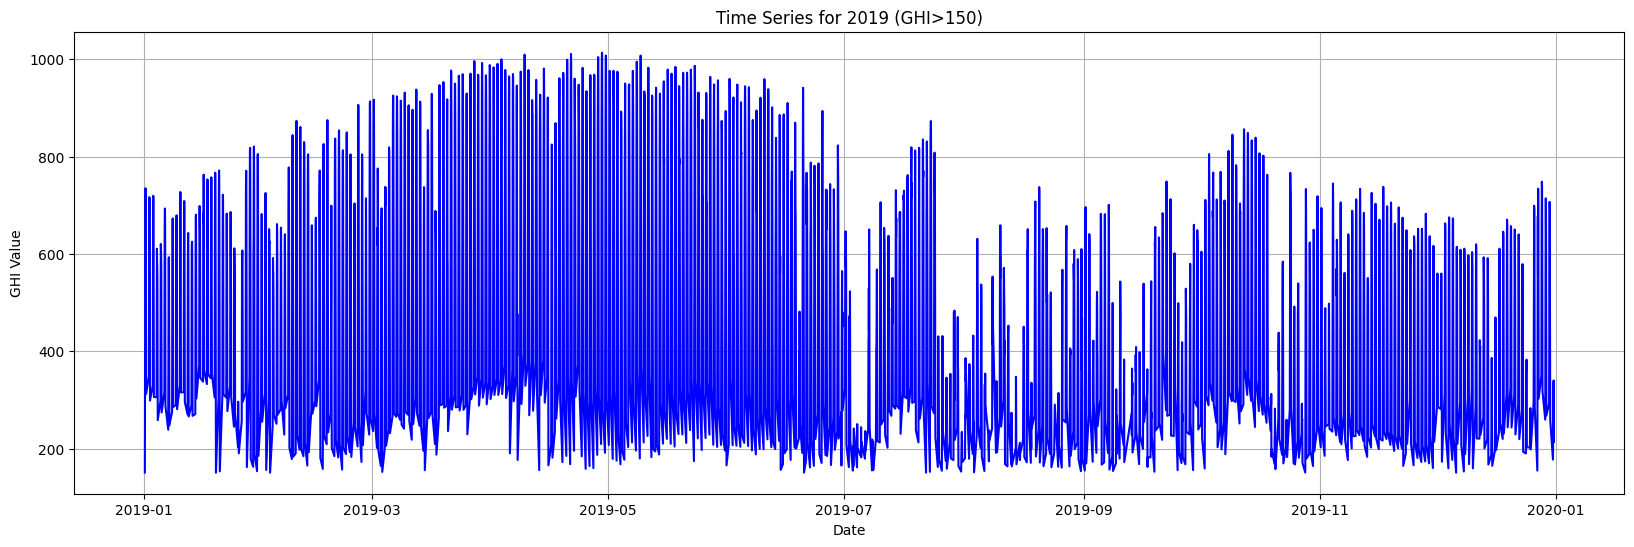

In [29]:
ghi = df[(df['Year'] == 2019)]
mask_ghi = ghi['GHI'] > 150
ghi_f = ghi[mask_ghi]

# Combine year, month, day, and hour columns into a single datetime column
ghi_f['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])

#time series for raw data
plt.figure(figsize=(20, 6))
plt.plot(ghi_f['Date'], ghi_f['GHI'], color='blue')
plt.title('Time Series for 2019 (GHI>150)')
plt.xlabel('Date')
plt.ylabel('GHI Value')
plt.grid(True)
plt.show()

Averaged Values

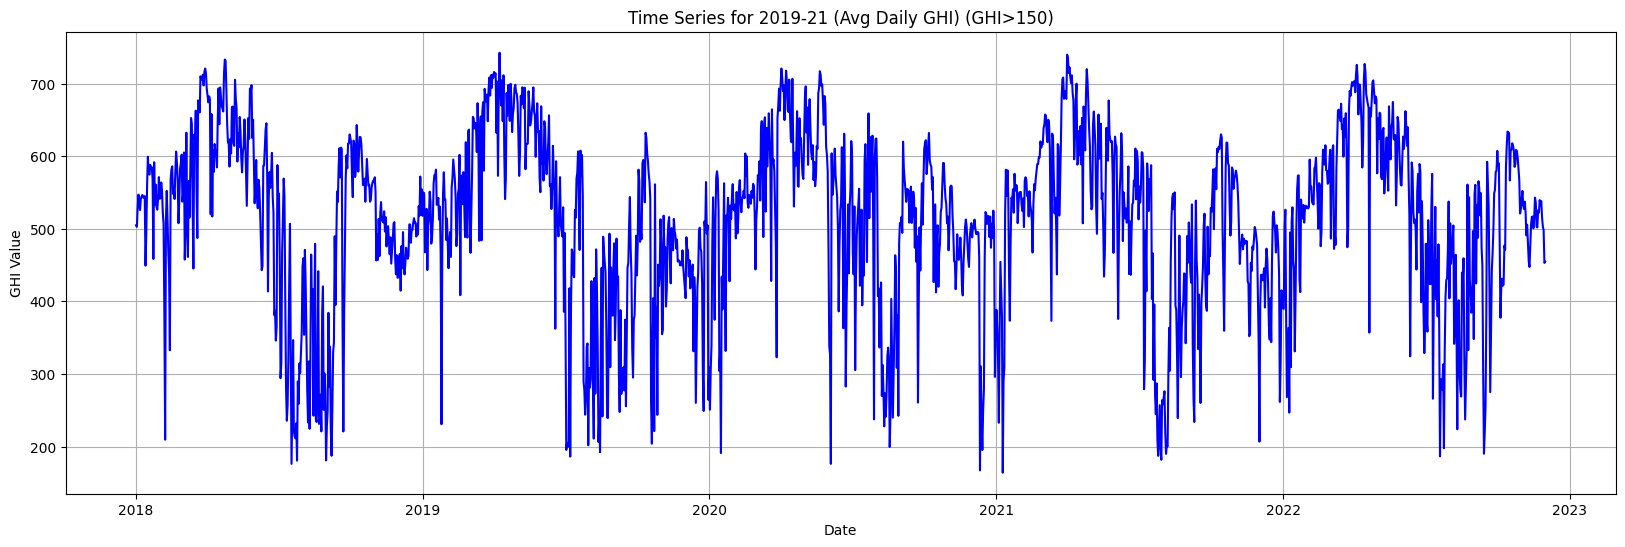

In [30]:
final_df.index = pd.to_datetime(final_df.index)
mask_range = (final_df.index.year >= 2018) & (final_df.index.year <= 2022)
ghi_f = final_df[mask_range]

# Plot time series
plt.figure(figsize=(20, 6))
plt.plot(ghi_f.index, ghi_f['GHI'], color='blue')
plt.title('Time Series for 2019-21 (Avg Daily GHI) (GHI>150)')
plt.xlabel('Date')
plt.ylabel('GHI Value')
plt.grid(True)
plt.show()

train test split

AVG VALUES

In [12]:
ghi_df = ghi_f[['GHI']]
train_test_ratio = 0.2
trainset, testset = train_test_split(ghi_df, test_size=train_test_ratio, shuffle=False)

print(trainset.shape)
print(testset.shape)

(1432, 1)
(359, 1)


In [28]:
print(trainset.tail())
print(testset.head())

                   GHI
date                  
2021-11-30  407.236667
2021-12-01  340.600000
2021-12-02  206.768000
2021-12-03  395.187143
2021-12-04  436.567778
                  GHI
date                 
2021-12-05  436.62875
2021-12-06  429.04625
2021-12-07  436.58000
2021-12-08  445.49750
2021-12-09  391.51375


Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#scaling values for faster model training
scaled_train = scaler.fit_transform(trainset)
scaled_test = scaler.fit_transform(testset)

print(*scaled_train[:5])
print(*scaled_test[:5])

[0.58915998] [0.5854385] [0.63145049] [0.66215539] [0.63864938]
[0.46252357] [0.44849876] [0.4624334] [0.47892745] [0.3790776]


creating sequences for PyTorch tensors

In [14]:
sequence_length = 30
X_train, y_train = [],[]
for i in range(len(scaled_train) - sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train) , np.array(y_train)

#convert data in PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape, y_train.shape

(torch.Size([1402, 30, 1]), torch.Size([1402, 30, 1]))

In [15]:
sequence_length = 50
X_test, y_test = [],[]
for i in range(len(scaled_test) - sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])

X_test, y_test = np.array(X_test) , np.array(y_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([309, 50, 1]), torch.Size([309, 50, 1]))

# LSTM Model

In [16]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
      out, _ = self.lstm(x)
      out = self.linear(out)
      return out

In [17]:
input_size = 1
num_layers = 2
hidden_size = 32
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [18]:
batch_size = 16
#DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
num_epochs = 50
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X, batch_y
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test, batch_y_test
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0148, Test Loss: 0.0170
Epoch [20/50] - Training Loss: 0.0146, Test Loss: 0.0167
Epoch [30/50] - Training Loss: 0.0145, Test Loss: 0.0170
Epoch [40/50] - Training Loss: 0.0144, Test Loss: 0.0168
Epoch [50/50] - Training Loss: 0.0143, Test Loss: 0.0170


plotting the learning curve

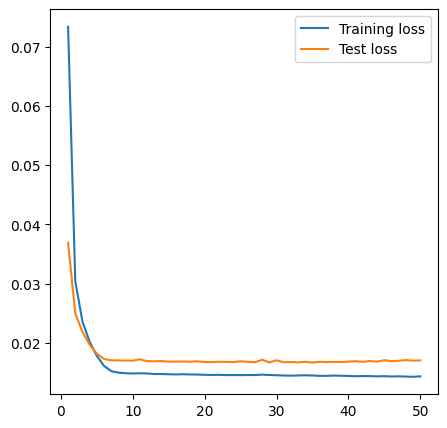

In [20]:
x = np.linspace(1,num_epochs,num_epochs)
plt.figure(figsize=(5,5))
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")

plt.legend()
plt.show()

#Plotting results

In [21]:
print(X_test.shape)
sequence_to_plot = X_test.squeeze().cpu().numpy()
print(sequence_to_plot.shape)
historical_data = sequence_to_plot[-1]

torch.Size([309, 50, 1])
(309, 50)


In [22]:
num_forecast_steps = 50
forecasted_values = []

with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value[0])
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = testset.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
combined_index = testset.index.append(future_dates)


<ipython-input-22-cb4dd2195685>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


In [23]:
print(testset.head(3))

                  GHI
date                 
2021-12-05  436.62875
2021-12-06  429.04625
2021-12-07  436.58000


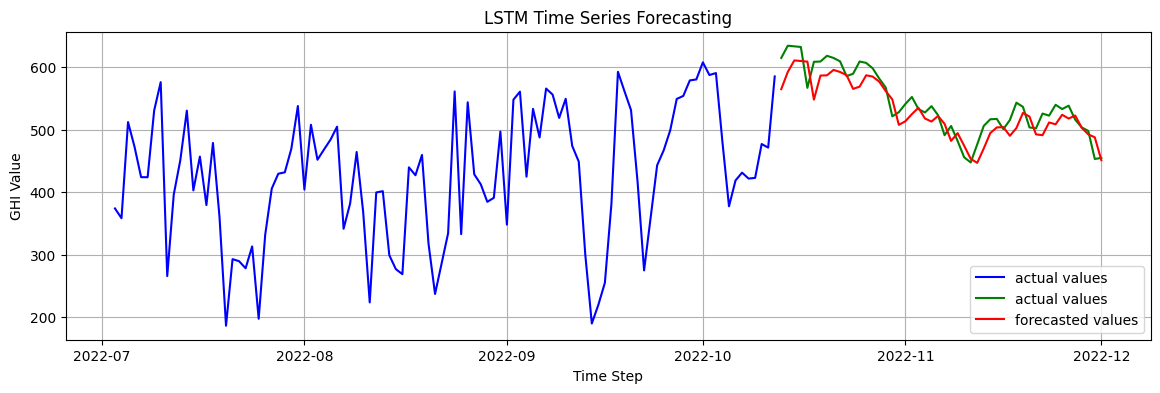

In [24]:
plt.rcParams['figure.figsize'] = [14, 4]

plt.plot(testset.index[-150:-50], testset.GHI[-150:-50], label="actual values", color="b")
original_cases = scaler.inverse_transform(scaled_test).flatten()
plt.plot(testset.index[-50:], original_cases[-50:], label='actual values', color='green')
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
plt.plot(testset.index[-50:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('GHI Value')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.grid(True)

Calculating errors


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE calculation
rmse = mean_squared_error(testset.GHI[-50:], forecasted_cases[-50:], squared=False)

# MAE calculation
mae = mean_absolute_error(testset.GHI[-50:], forecasted_cases[-50:])

# MBE calculation
mbe = np.mean(testset.GHI[-50:] - forecasted_cases)

print("RMSE:", rmse)
print("MAE:", mae)
print("MBE:", mbe)


RMSE: 24.535093552604835
MAE: 20.416405936957464
MBE: 12.84270615939669


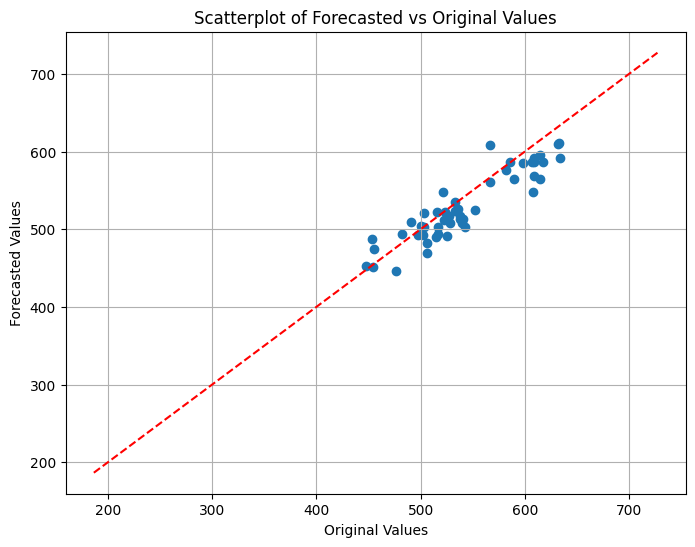

In [26]:
# Assuming actual values are in testset.GHI and forecasted values are in forecasted_cases

plt.figure(figsize=(8, 6))
plt.scatter(testset.GHI[-50:], forecasted_cases)
plt.plot([testset.GHI.min(), testset.GHI.max()], [testset.GHI.min(), testset.GHI.max()], color='red', linestyle='--')
plt.title('Scatterplot of Forecasted vs Original Values')
plt.xlabel('Original Values')
plt.ylabel('Forecasted Values')
plt.grid(True)
plt.show()